In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"locphan010","key":"f802df2821ccc7d9255c3f49b72e146c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!kaggle datasets download -d laotse/credit-risk-dataset


Dataset URL: https://www.kaggle.com/datasets/laotse/credit-risk-dataset
License(s): CC0-1.0
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 109MB/s]


In [12]:
import zipfile

# Path to the downloaded ZIP file
zip_file_path = '/content/credit-risk-dataset.zip'

# Extract to a folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/credit-risk-dataset')

df = pd.read_csv('/content/credit-risk-dataset/credit_risk_dataset.csv')

# Inspect the data
print(df.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


In [15]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

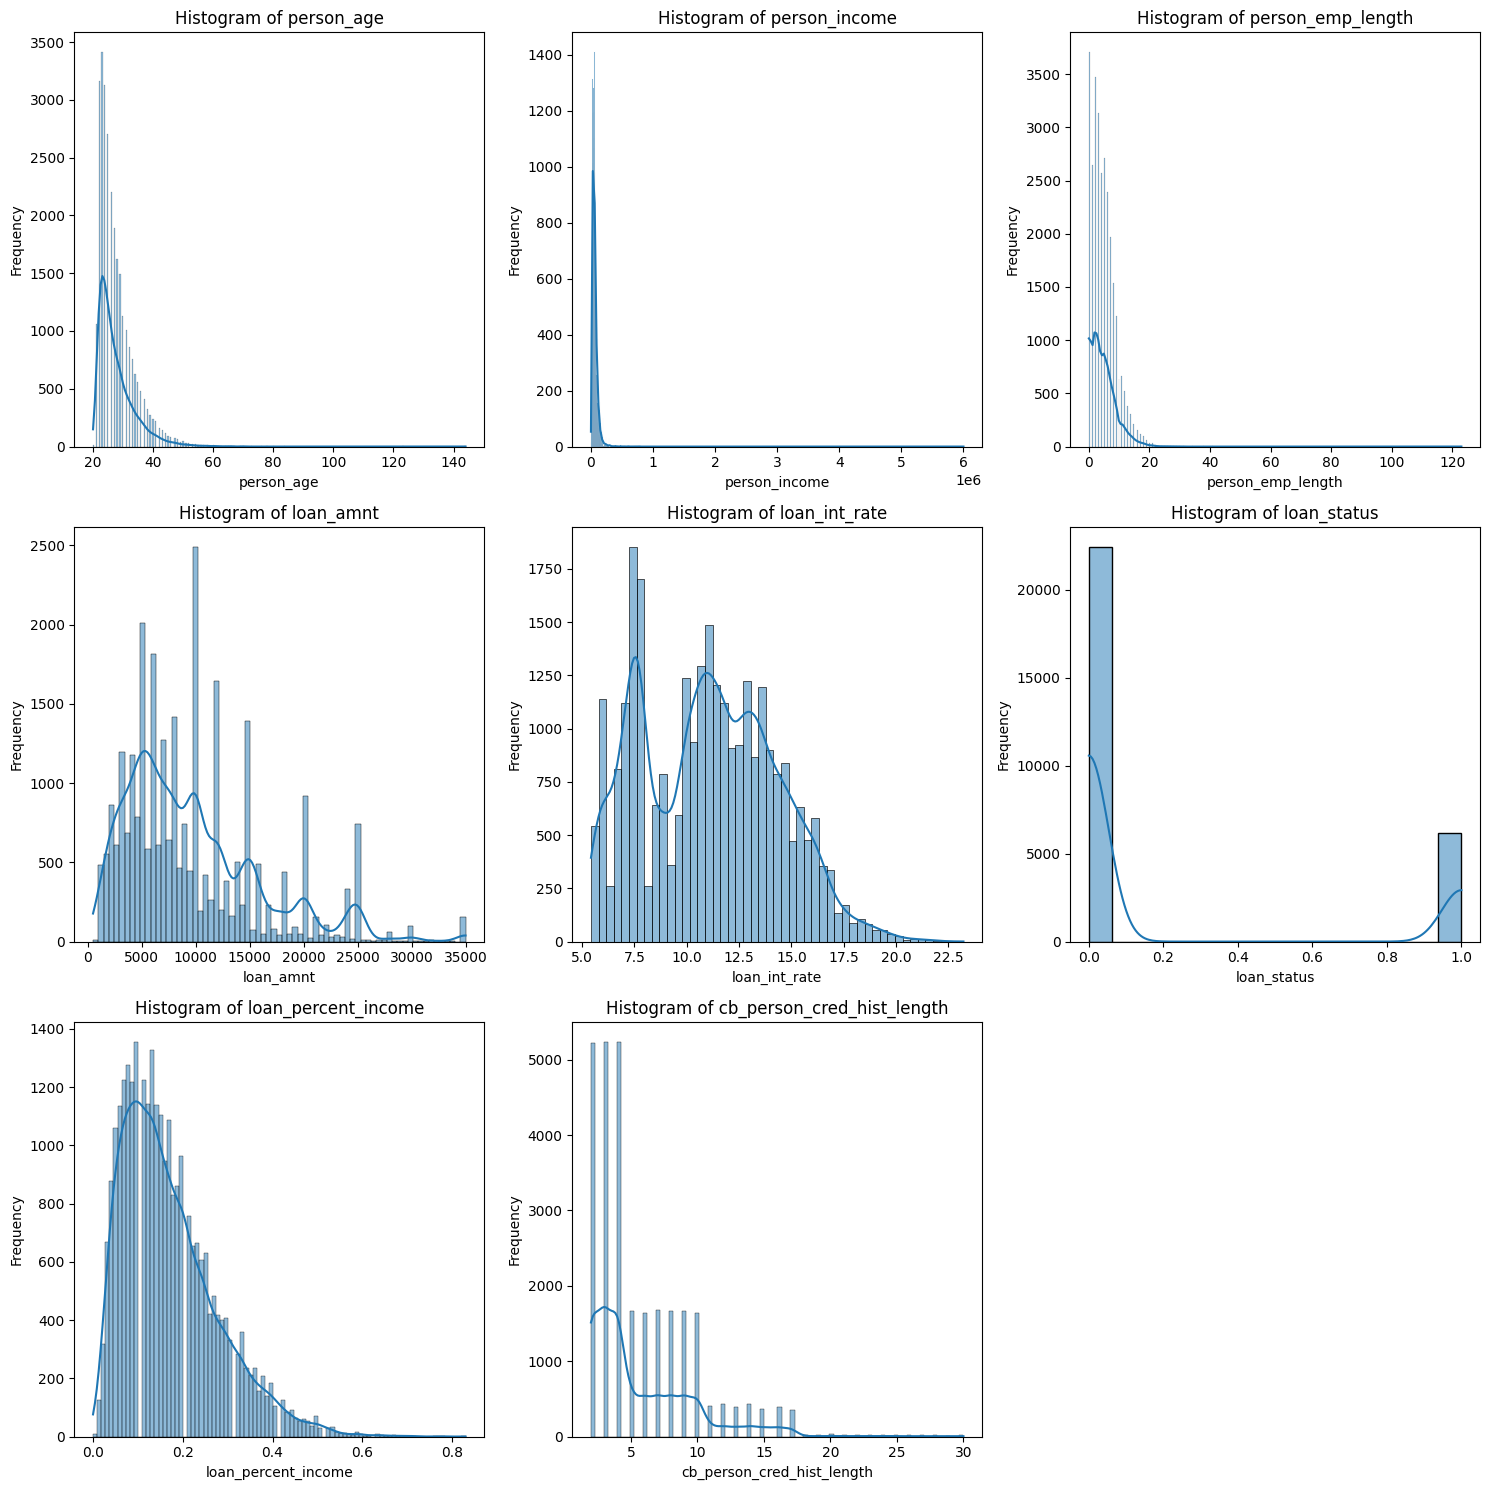

In [21]:
# Create subplots: Determine the number of rows and columns needed based on the number of numeric columns
numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
num_cols = 3  # You can adjust the number of columns in the subplot grid
num_rows = (len(numeric_cols) // num_cols) + (1 if len(numeric_cols) % num_cols != 0 else 0)

# Set up the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Iterate through each numeric column and plot on the corresponding subplot
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])  # Plot histogram with KDE
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Comment on distributions
The dataset is imbalance as can be seen in loan_status histograms. This creates bias when making prediction. There are three solutions a) chosing right evaluation metrics - when dealing with imbalance data accuracy partially measure the accuracy of trained model, b) sample data either through oversampling or undersampling, or c) programatic sampling by assigning smaller/greater weights to greater/smaller data instances.

To save time, I will later use ROC curve to measure the accuracy of this imbalance data set

In [13]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


In [14]:
# Drop empty df
df.dropna(axis=0,inplace=True)


## Check for Logic Fallacy
We will drop entry where person age is greater than 80 years old, age < employment length

In [16]:
df = df[~((df['person_age'] > 80) | (df['person_age'] < df['person_emp_length']))]

# Preprocess Data

In [29]:
X = df.drop(['loan_status','loan_grade'],axis=1)
y = df['loan_grade']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [46]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Encode categorical features in both training and testing sets
for col in categorical_cols:
    x_train[col] = label_encoder.fit_transform(x_train[col])
    x_test[col] = label_encoder.transform(x_test[col])

# Initialize and train the XGBoost model
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)  # Get probabilities for ROC AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Use probabilities

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")


Accuracy: 0.9455212152959664
ROC AUC: 0.993097026045402


array([1, 3, 3, ..., 1, 2, 1])

## Comment on Accuracy and ROC AUC score

Even though Accuracy is less optimistic with a score of 94% over 99%, ROC AUC is prefered for imbalanced data set because it plots the True Positive Rate (TPR) vs. False Positive Rate (FPR), meaning ROC focuses on the performance of the model accross all classification threshold

# Explainable Machine Learning
In this section I will explore the weights the model used to predict test data set

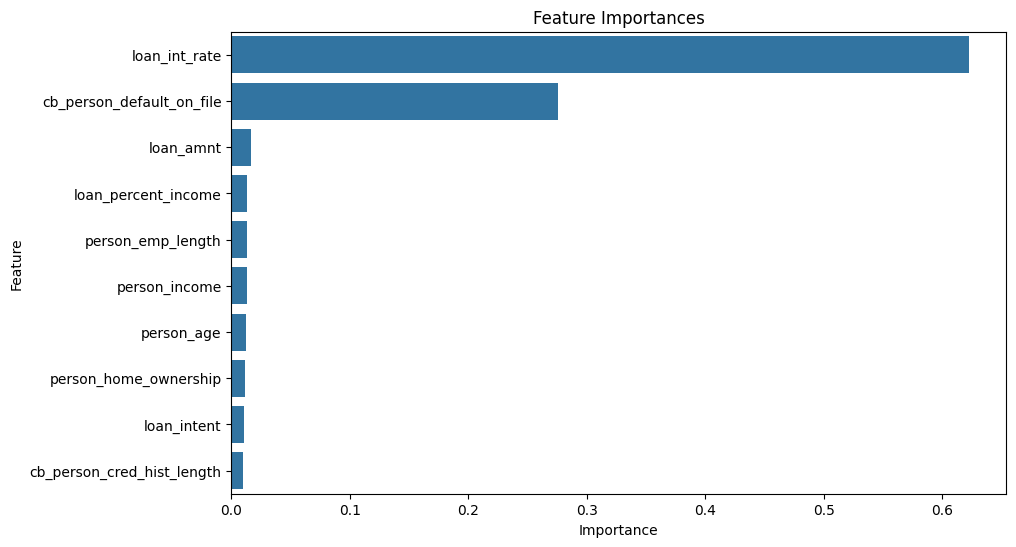

In [31]:
# Get feature importances from the trained XGBoost model
feature_importances = model.feature_importances_

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Comment on correlation

According to Feature Importanes plot, the three most importance dimension that affect the segment of loan grade are loan interest rate, historical default, and loan ammount

In [41]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=5e90e60586e3d9d16868cd32851b94cdacea116646ee3505c6face45e5c7aa43
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [ ]:
from fpdf import FPDF
import numpy as np
import os

pred_to_grade = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E'
}

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Loan Report', border=0, ln=1, align='C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', align='C')

    def add_table(self, input_data, prediction):
        self.set_text_color(0)
        self.set_font('Arial', '', 12)
        self.cell(0, 10, 'Borrower Information:', ln=1, fill=False)

        # Add table rows with alternating colors
        row_color_1 = (204, 255, 204)  # Light green
        row_color_2 = (255, 255, 255)  # White
        row_colors = [row_color_1, row_color_2]

        for idx, (key, value) in enumerate(input_data.items()):
            # Alternate row colors
            row_color = row_colors[idx % 2]  # Alternate between the two colors

            if key == 'loan_amnt':
                self.set_font('Arial', 'B', 12)  # Bold for loan amount
            else:
                self.set_font('Arial', '', 12)

            display_value = value if key != 'loan_amnt' else f"{value} (Predicted: {pred_to_grade[int(prediction)]})"

            self.set_fill_color(*row_color)  # Set fill color
            self.cell(90, 10, key.replace("_", " ").title(), border=1, fill=True)
            self.cell(90, 10, str(display_value), border=1, ln=1, fill=True)


def generate_pdf(input_data, prediction,  plots):
    pdf = PDF()
    pdf.add_page()

    # Add the borrower table with prediction
    pdf.add_table(input_data, prediction)

    # Save the PDF
    pdf.output("Loan_Report.pdf")
    print("PDF report generated successfully!")

# Example input data
borrower_data = {
    'person_age': 35,
    'person_income': 55000,
    'person_home_ownership': 'RENT',
    'person_emp_length': 5,
    'loan_intent': 'EDUCATION',
    'loan_amnt': 2000,
    'loan_int_rate': 3,
    'loan_percent_income': 0.36,
    'cb_person_default_on_file': 0,
    'cb_person_cred_hist_length': 2
}
borrower_df = pd.DataFrame([borrower_data])

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Assuming x_train is already available and contains encoded categorical data
categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if col in borrower_df.columns:
        borrower_df[col] = label_encoder.fit(x_train[col].astype(str)).transform(borrower_df[col].astype(str))

# Convert borrower_df to the same format as the training data
borrower_df = borrower_df[x_train.columns]  # Ensure column order matches the training data
borrower_df = borrower_df.apply(pd.to_numeric, errors='coerce')

# Predict using the model
prediction = model.predict(borrower_df)[0]

generate_pdf(borrower_data, prediction, percentiles)


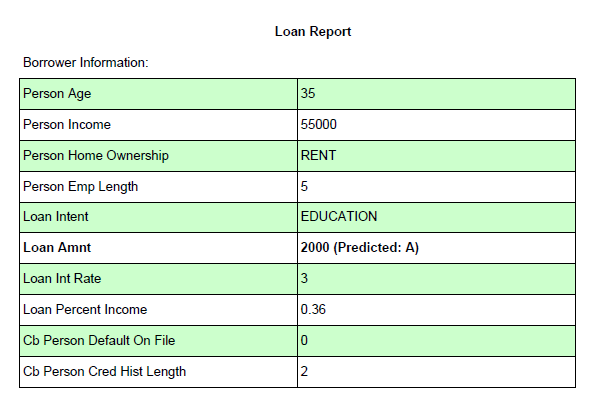

# Conclusion

For credit scoring task, model achieve high accuracy ~99%. However, it's always good to compare our credit scoring with third-party data like FICO.